<a href="https://colab.research.google.com/github/dharambirpoddar/BIrd_urdf/blob/main/Bird2_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scipy


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras import regularizers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import interpolate

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyproj
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Prep

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Data')
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,t_gps_sec,alt,xyz_0,t_xyz_sec,xyz_1,xyz_2,q_0,...,t_c_sec,c2_pitch,c3_throttle,roll,pitch,yaw,lon,lat,x_axis,y_axis
0,0,0,0,0.000000,0.000000,-0.025227,0.000000,0.051710,0.036490,-0.550386,...,0.000000,1500.000000,998.0,-3.618678,0.381745,113.162801,88.303930,22.555872,16795.139732,2.501964e+06
1,1,1,1,0.109609,79.122426,0.020328,0.109473,0.099811,-0.002836,-0.549877,...,0.109605,1500.000000,998.0,-3.608857,0.847924,113.216640,88.303930,22.555873,16795.123327,2.501964e+06
2,2,2,2,0.219218,138.425565,0.039619,0.218945,-0.045201,-0.048510,-0.550789,...,0.219210,1500.000000,998.0,-3.411084,1.019822,113.090701,88.303930,22.555873,16795.107931,2.501964e+06
3,3,3,3,0.328827,136.063858,0.035581,0.328418,-0.075888,-0.091753,-0.554199,...,0.328815,1500.000000,998.0,-3.132182,0.622868,112.641951,88.303930,22.555873,16795.095677,2.501964e+06
4,4,4,4,0.438436,133.702151,0.001672,0.437890,-0.104955,-0.094228,-0.558308,...,0.438420,1500.000000,998.0,-3.055991,-0.031660,112.095528,88.303930,22.555873,16795.083423,2.501964e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,4995,4995,547.497137,6042.560744,-0.787299,546.815530,0.856096,0.188109,0.948763,...,547.477516,1386.991772,1600.0,5.773752,-6.283896,-36.183352,88.304484,22.556059,16852.848974,2.501983e+06
4996,4996,4996,4996,547.606746,6095.848595,0.444530,546.925003,0.370571,-0.142470,0.952545,...,547.587122,1397.350327,1600.0,2.784687,-3.387301,-35.247454,88.304481,22.556063,16852.518237,2.501983e+06
4997,4997,4997,4997,547.716355,6149.136446,-0.570763,547.034475,-1.010787,-0.239736,0.949180,...,547.696727,1386.512745,1600.0,4.434605,1.472464,-36.317071,88.304477,22.556067,16852.187500,2.501984e+06
4998,4998,4998,4998,547.825964,6202.424297,-0.896305,547.143948,1.305357,0.240863,0.950381,...,547.806332,1375.675163,1600.0,-0.580218,2.558557,-36.093664,88.304474,22.556071,16851.856763,2.501984e+06


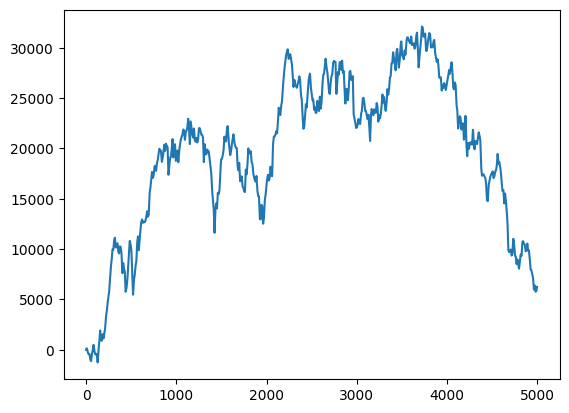

In [ ]:
plt.plot(df['alt'])

In [ ]:

def gps2xy(longitude,latitude):
  # Example Coordinates (Adjust these to your actual data)
  #latitude = 28.6129  # Example: Delhi, India
  #longitude = 77.2304

  # Define the source and target coordinate systems
  wgs84 = pyproj.CRS('EPSG:4326')  # Standard GPS coordinates

  # Determine UTM zone for your location in India
  # India covers multiple UTM zones (40-47)
  # Use a reference source (e.g., https://epsg.io/) to find the zone
  # for your specific coordinates. Here, we'll assume zone 46 for Delhi.
  utm_zone = 46

  # Construct the UTM CRS for India zone
  utm_crs = pyproj.CRS(f'EPSG:326{utm_zone}')

  # Create a transformation object
  transformer = pyproj.Transformer.from_crs(wgs84, utm_crs, always_xy=True)

  # Perform the transformation
  x, y = transformer.transform(longitude, latitude)

  #print(f"Indian UTM Coordinates (Zone {utm_zone}): X = {x:.2f}, Y = {y:.2f}")
  return [x,y]

In [ ]:
xx=[]
yy=[]
for i in range(df.shape[0]):
  x=df['lon'][i]
  y=df['lat'][i]
  gps2xy(x,y)
  xx.append(gps2xy(x,y)[0])
  yy.append(gps2xy(x,y)[1])

In [ ]:
print(xx)

[16795.139731963864, 16795.123326873872, 16795.107931392675, 16795.09567716904, 16795.0834229443, 16795.07116871793, 16795.058914493187, 16795.046660268446, 16795.034406042425, 16795.02250427514, 16795.018074631807, 16795.01364498888, 16795.0092153445, 16795.004785701458, 16795.00035605696, 16794.99592641258, 16794.991496770876, 16794.98706712766, 16794.982637484674, 16794.98391573009, 16794.985337327, 16794.986758925428, 16794.98818052397, 16794.98960212106, 16794.991023719544, 16794.99244531669, 16794.993866915116, 16794.995288510923, 16794.991021661903, 16794.98494235467, 16794.978863048542, 16794.97278374125, 16794.966704435355, 16794.960625128006, 16794.954545822053, 16794.948466514878, 16794.9423872091, 16794.945076547912, 16794.951899542357, 16794.958722535695, 16794.96554553014, 16794.97236852598, 16794.979191519145, 16794.986014515103, 16794.99283750949, 16794.999660503934, 16795.054270438442, 16795.145590809, 16795.236911179905, 16795.328231552034, 16795.41955192288, 16795.51

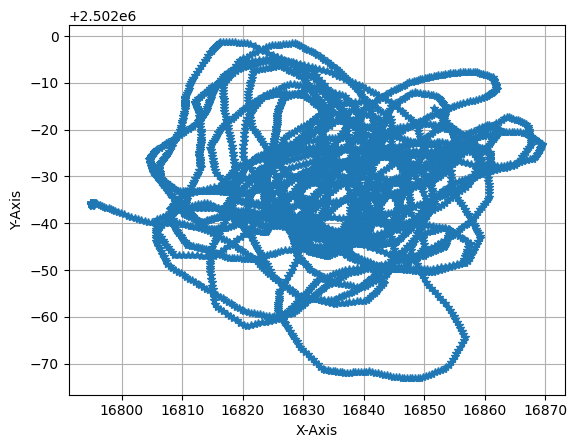

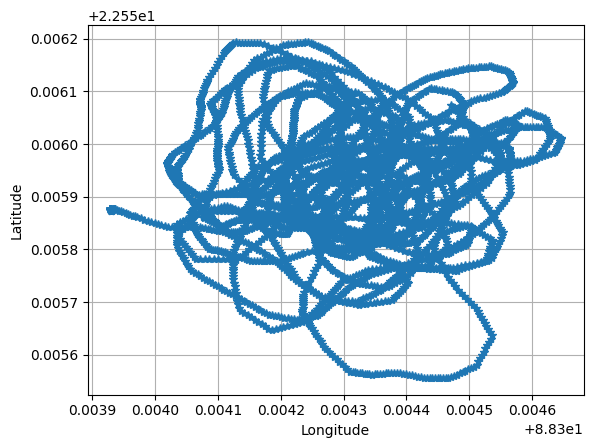

In [ ]:
plt.plot(xx,yy,'*-')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.grid()
plt.show()
plt.plot(df['lon'],df['lat'],'*-')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [ ]:
xx = xx[:df.shape[0]]
yy = yy[:df.shape[0]]
df['x_axis'] = xx
df['y_axis'] = yy
#df.to_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Data')

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Data')


In [ ]:
df['x_axis'] = df['x_axis']-df['x_axis'][0]
df['y_axis'] = df['y_axis']-df['y_axis'][0]
columns_to_average = ['t_xyz_sec', 't_c_sec', 't_q_sec','t_gps_sec']
df['time'] = df[columns_to_average].mean(axis=1)

df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2','t_gps_sec','t_c_sec','t_xyz_sec','t_q_sec'])



,alt,xyz_0,xyz_1,xyz_2,q_0,q_1,q_2,q_3,c1_roll,c2_pitch,c3_throttle,roll,pitch,yaw,lon,lat,x_axis,y_axis,time
0,0.000000,-0.025227,0.051710,0.036490,-0.550386,0.020168,0.024520,-0.834306,1500.000000,1500.000000,998.0,-3.618678,0.381745,113.162801,88.303930,22.555872,0.000000,0.000000,0.000000
1,79.122426,0.020328,0.099811,-0.002836,-0.549877,0.023504,0.022219,-0.834619,1500.000000,1500.000000,998.0,-3.608857,0.847924,113.216640,88.303930,22.555873,-0.016405,0.038451,0.109539
2,138.425565,0.039619,-0.045201,-0.048510,-0.550789,0.023829,0.019927,-0.834066,1500.000000,1500.000000,998.0,-3.411084,1.019822,113.090701,88.303930,22.555873,-0.031801,0.072522,0.219079
3,136.063858,0.035581,-0.075888,-0.091753,-0.554199,0.019677,0.019730,-0.831916,1500.000000,1500.000000,998.0,-3.132182,0.622868,112.641951,88.303930,22.555873,-0.044055,0.092967,0.328618
4,133.702151,0.001672,-0.104955,-0.094228,-0.558308,0.014664,0.022273,-0.829204,1500.000000,1500.000000,998.0,-3.055991,-0.031660,112.095528,88.303930,22.555873,-0.056309,0.113412,0.438157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6042.560744,-0.787299,0.856096,0.188109,0.948763,0.030803,-0.067652,-0.307059,1496.861132,1386.991772,1600.0,5.773752,-6.283896,-36.183352,88.304484,22.556059,57.709242,18.894377,547.148932
4996,6095.848595,0.444530,0.370571,-0.142470,0.952545,0.014202,-0.035515,-0.301867,1446.501054,1397.350327,1600.0,2.784687,-3.387301,-35.247454,88.304481,22.556063,57.378505,19.356029,547.258471
4997,6149.136446,-0.570763,-1.010787,-0.239736,0.949180,0.040764,0.000142,-0.311877,1343.875790,1386.512745,1600.0,4.434605,1.472464,-36.317071,88.304477,22.556067,57.047768,19.817680,547.368011
4998,6202.424297,-0.896305,1.305357,0.240863,0.950381,0.002106,0.022799,-0.309652,1241.250527,1375.675163,1600.0,-0.580218,2.558557,-36.093664,88.304474,22.556071,56.717031,20.279332,547.477550


In [ ]:
df_n=df[['time','xyz_0','xyz_1','xyz_2','roll','pitch','yaw','x_axis','y_axis','alt','c1_roll','c2_pitch','c3_throttle']]
#df_n.to_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Filter')

In [ ]:
columns_to_average = ['t_xyz_sec', 't_c_sec', 't_q_sec','t_gps_sec']
df['time'] = df[columns_to_average].mean(axis=1)
df



# DNN

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Filter')


In [ ]:
Roll_max=df['roll'].max()
Roll_min=df['roll'].min()
Pitch_min=df['pitch'].min()
Pitch_max=df['pitch'].max()
Yaw_min=df['yaw'].min()
Yaw_max=df['yaw'].max()
C_min=900
C_max=2100

Normalization

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Filter')

df['roll']=(df['roll']-Roll_min)/(Roll_max-Roll_min)
df['pitch']=(df['pitch']-Pitch_min)/(Pitch_max-Pitch_min)
df['yaw']=(df['yaw']-Yaw_min)/(Yaw_max-Yaw_min)
df['c1_roll']=(df['c1_roll']-C_min)/(C_max-C_min)
df['c2_pitch']=(df['c2_pitch']-C_min)/(C_max-C_min)
df['c3_throttle']=(df['c3_throttle']-C_min)/(C_max-C_min)

df['x_norm']=(df['x_axis']-df['x_axis'].min())/(df['x_axis'].max()-df['x_axis'].min())
df['y_norm']=(df['y_axis']-df['y_axis'].min())/(df['y_axis'].max()-df['y_axis'].min())
df['alt_norm']=(df['alt']-df['alt'].min())/(df['alt'].max()-df['alt'].min())

df['time_diff']=df['time'].shift(-1)-df['time']
df['time_diff_norm']=(df['time_diff']-df['time_diff'].min())/(df['time_diff'].max()-df['time_diff'].min())

In [ ]:
df

,Unnamed: 0,time,xyz_0,xyz_1,xyz_2,roll,pitch,yaw,x_axis,y_axis,alt,c1_roll,c2_pitch,c3_throttle,x_norm,y_norm,alt_norm,time_diff,time_diff_norm
0,0,0.000000,-0.025227,0.051710,0.036490,0.560823,0.493889,0.814841,0.000000,0.000000,0.000000,0.500000,0.500000,0.081667,0.002649,0.513140,0.037621,0.109539,0.577295
1,1,0.109539,0.020328,0.099811,-0.002836,0.560909,0.499154,0.814991,-0.016405,0.038451,79.122426,0.500000,0.500000,0.081667,0.002429,0.513676,0.039992,0.109539,0.577588
2,2,0.219079,0.039619,-0.045201,-0.048510,0.562649,0.501096,0.814641,-0.031801,0.072522,138.425565,0.500000,0.500000,0.081667,0.002222,0.514151,0.041769,0.109539,0.577734
3,3,0.328618,0.035581,-0.075888,-0.091753,0.565103,0.496612,0.813394,-0.044055,0.092967,136.063858,0.500000,0.500000,0.081667,0.002058,0.514435,0.041698,0.109539,0.577539
4,4,0.438157,0.001672,-0.104955,-0.094228,0.565773,0.489220,0.811875,-0.056309,0.113412,133.702151,0.500000,0.500000,0.081667,0.001893,0.514720,0.041628,0.109539,0.577734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,547.148932,-0.787299,0.856096,0.188109,0.643447,0.418607,0.399730,57.709242,18.894377,6042.560744,0.497384,0.405826,0.583333,0.777391,0.776328,0.218708,0.109539,0.200000
4996,4996,547.258471,0.444530,0.370571,-0.142470,0.617152,0.451321,0.402332,57.378505,19.356029,6095.848595,0.455418,0.414459,0.583333,0.772951,0.782759,0.220305,0.109539,1.000000
4997,4997,547.368011,-0.570763,-1.010787,-0.239736,0.631666,0.506208,0.399359,57.047768,19.817680,6149.136446,0.369896,0.405427,0.583333,0.768511,0.789189,0.221902,0.109539,0.200000
4998,4998,547.477550,-0.896305,1.305357,0.240863,0.587552,0.518474,0.399980,56.717031,20.279332,6202.424297,0.284375,0.396396,0.583333,0.764071,0.795620,0.223499,0.109539,1.000000


In [ ]:
#df.to_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Filter_norm')


In [ ]:
#plt.plot(df['x_axis'][:5000],df['y_axis'][:5000],'--o')

Learning !!!!!

In [ ]:

X = df[['time_diff_norm','roll','pitch','yaw','x_norm','y_norm','alt_norm']]
y = df[['c1_roll','c2_pitch','c3_throttle']]

In [ ]:
#time Series Split
training_size=int(len(df)*0.65)
X_train,X_test=df.loc[:training_size,['time_diff_norm','roll','pitch','yaw','x_norm','y_norm','alt_norm']],df.loc[training_size:,['time_diff','roll','pitch','yaw','x_norm','y_norm','alt_norm']]
y_train,y_test=df.loc[:training_size,['c1_roll','c2_pitch','c3_throttle']],df.loc[training_size:,['c1_roll','c2_pitch','c3_throttle']]

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(7,)))  # Input layer, 32 neurons
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(16, activation='relu'))  # Hidden Layer
model.add(Dense(3, activation='linear'))  # Output layer with 3 neurons (matching your output parameters)


In [ ]:
optimizer = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
history=model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test),verbose=1)


training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)  # Assuming you trained for 1000 epochs

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.show()
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: nan
Test accuracy: 0.9497143030166626


# Offset from real Data


,Unnamed: 0.1,Unnamed: 0,time,xyz_0,xyz_1,xyz_2,roll,pitch,yaw,x_axis,y_axis,alt,c1_roll,c2_pitch,c3_throttle,x_norm,y_norm,alt_norm,time_diff
0,0,0,0.000000,-0.025227,0.051710,0.036490,0.560823,0.493889,0.814841,0.000000,0.000000,0.000000,0.500000,0.500000,0.081667,0.002649,0.513140,0.037621,0.109539
1,1,1,0.109539,0.020328,0.099811,-0.002836,0.560909,0.499154,0.814991,-0.016405,0.038451,79.122426,0.500000,0.500000,0.081667,0.002429,0.513676,0.039992,0.109539
2,2,2,0.219079,0.039619,-0.045201,-0.048510,0.562649,0.501096,0.814641,-0.031801,0.072522,138.425565,0.500000,0.500000,0.081667,0.002222,0.514151,0.041769,0.109539
3,3,3,0.328618,0.035581,-0.075888,-0.091753,0.565103,0.496612,0.813394,-0.044055,0.092967,136.063858,0.500000,0.500000,0.081667,0.002058,0.514435,0.041698,0.109539
4,4,4,0.438157,0.001672,-0.104955,-0.094228,0.565773,0.489220,0.811875,-0.056309,0.113412,133.702151,0.500000,0.500000,0.081667,0.001893,0.514720,0.041628,0.109539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,4995,547.148932,-0.787299,0.856096,0.188109,0.643447,0.418607,0.399730,57.709242,18.894377,6042.560744,0.497384,0.405826,0.583333,0.777391,0.776328,0.218708,0.109539
4996,4996,4996,547.258471,0.444530,0.370571,-0.142470,0.617152,0.451321,0.402332,57.378505,19.356029,6095.848595,0.455418,0.414459,0.583333,0.772951,0.782759,0.220305,0.109539
4997,4997,4997,547.368011,-0.570763,-1.010787,-0.239736,0.631666,0.506208,0.399359,57.047768,19.817680,6149.136446,0.369896,0.405427,0.583333,0.768511,0.789189,0.221902,0.109539
4998,4998,4998,547.477550,-0.896305,1.305357,0.240863,0.587552,0.518474,0.399980,56.717031,20.279332,6202.424297,0.284375,0.396396,0.583333,0.764071,0.795620,0.223499,0.109539


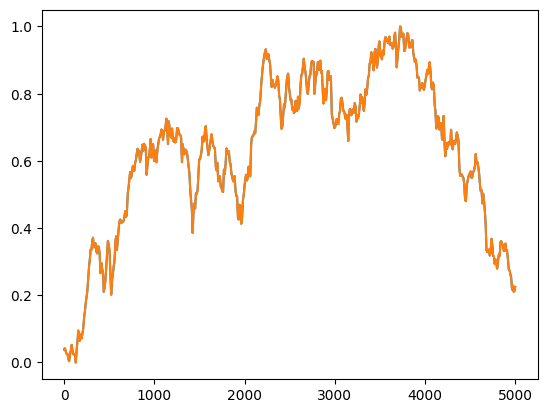

In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/resampleBird2Filter_norm')
delta=0.0
df2['roll'] = df2['roll'] + delta
df2['pitch'] = df2['pitch'] + delta
df2['yaw'] = df2['yaw'] + delta
df2['x_norm']=df2['x_norm']+delta
df2['y_norm']=df2['y_norm']+delta
df2['alt_norm']=df2['alt_norm']+delta

#checking
plt.plot(df2['alt_norm'])
plt.plot(df['alt_norm'])
df2

157/157 [==============================] - 0s 2ms/step


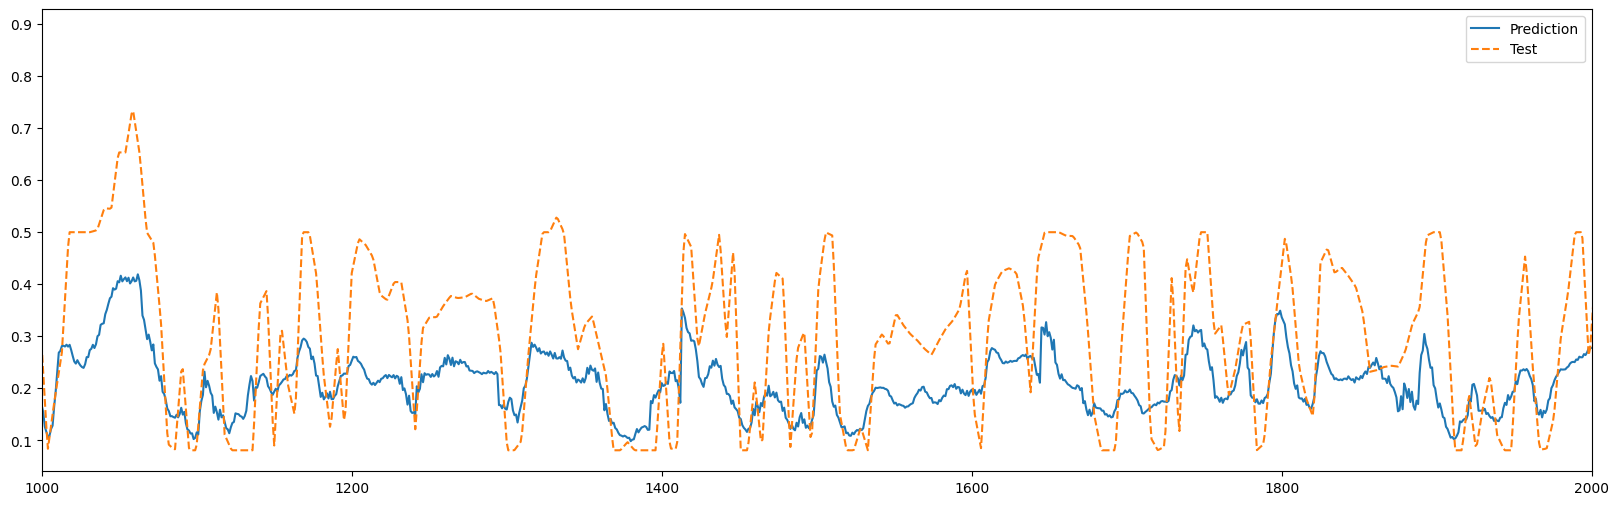

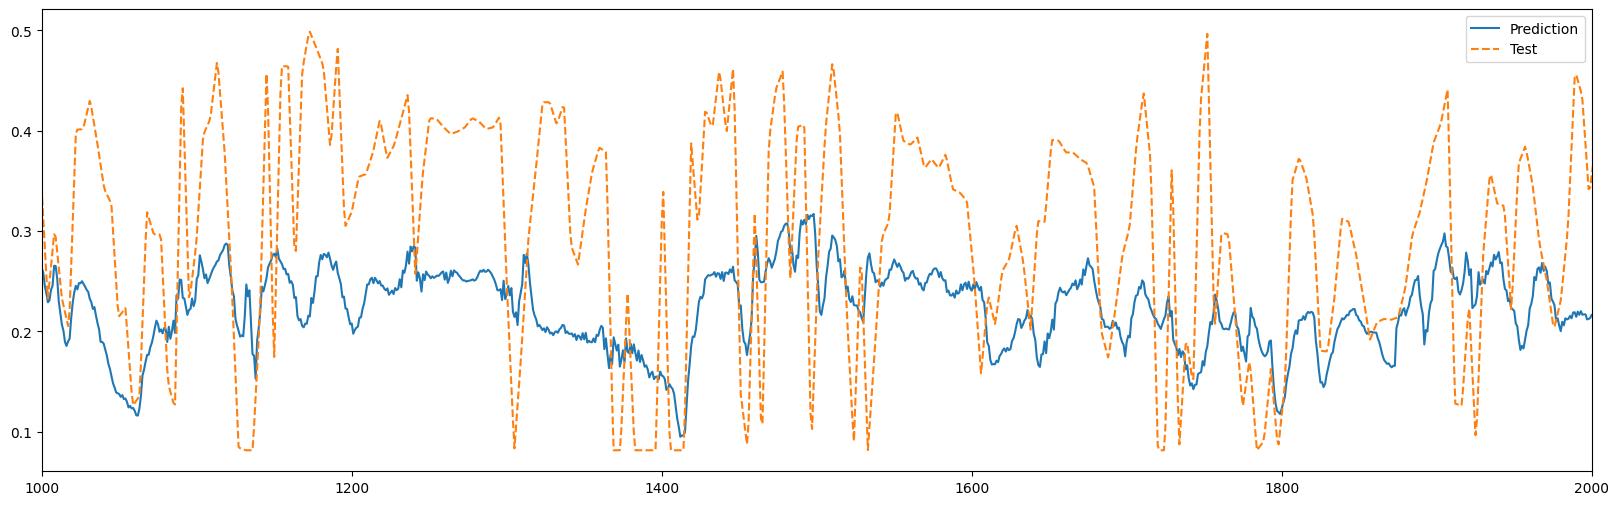

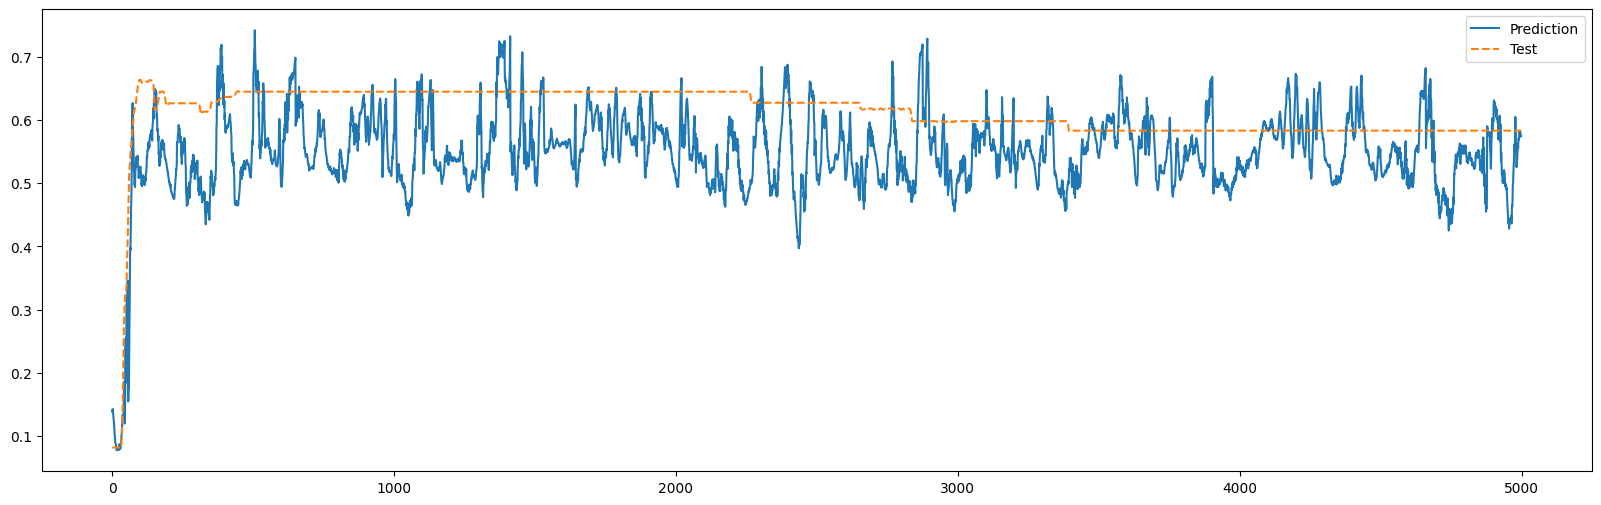

In [ ]:
df_test=df2[['time_diff','roll','pitch','yaw','x_norm','y_norm','alt_norm']]
predictions = model.predict(df_test) #Prediction
plt.figure(figsize=(20, 6))
plt.plot(predictions[:,0], label='Prediction')
plt.plot(df['c1_roll'],'--',label='Test')
plt.xlim(1000,2000)

plt.legend()
plt.show()
plt.figure(figsize=(20, 6))
plt.plot(predictions[:,1],label='Prediction')
plt.plot(df['c2_pitch'],'--',label='Test')
plt.xlim(1000,2000)
plt.legend()
plt.show()
plt.figure(figsize=(20, 6))
plt.plot(predictions[:,2],label='Prediction')
plt.plot(df['c3_throttle'],'--',label="Test")
plt.legend()
plt.show()

# Validation with Bird 1

In [ ]:
df_b1=pd.read_csv('/content/drive/MyDrive/Dharambir MasterThesis/NN Code/normBird_data')


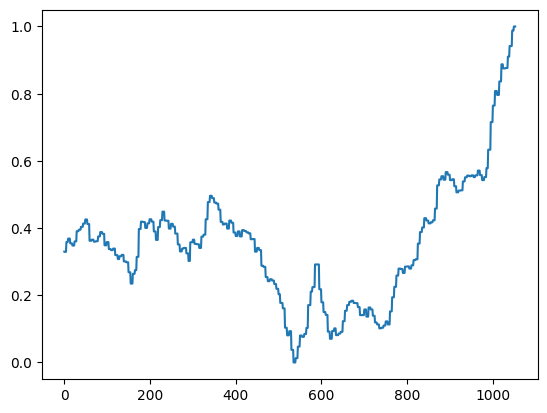

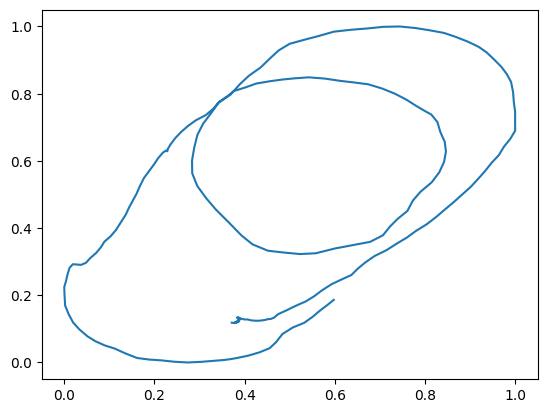

In [ ]:
plt.plot(df_b1['Alt_norm'])
plt.show()
plt.plot(df_b1['x_norm'],df_b1['y_norm'])

In [ ]:
df_b1['Time_diff']=df_b1['TimeUS_diff']/1000000

33/33 [==============================] - 0s 1ms/step
[[0.28884465 0.1360846  0.5750708 ]
 [0.2859492  0.14048795 0.57356286]
 [0.27876794 0.14620173 0.5750304 ]
 ...
 [0.14593942 0.145561   0.70849955]
 [0.20023042 0.14356881 0.65620077]
 [0.26939127 0.12286625 0.60774255]]


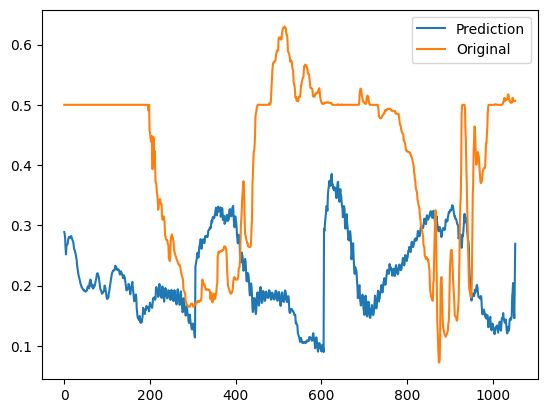

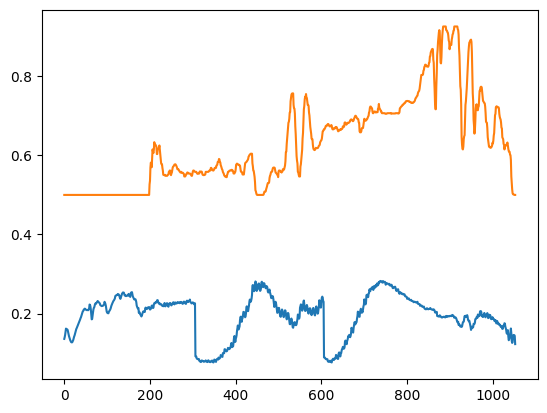

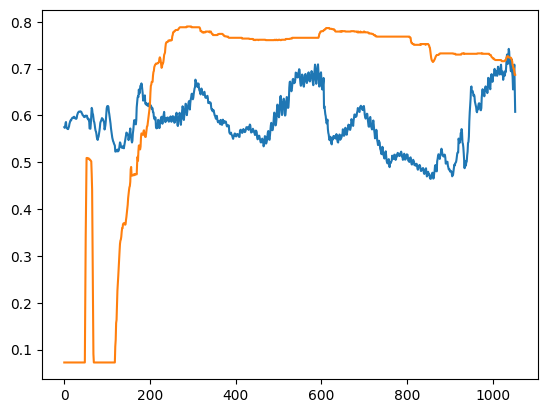

In [ ]:
df_test=df_b1[['Time_diff','Roll','Pitch','Yaw','x_norm','y_norm','Alt_norm']]

predictions = model.predict(df_test)
print(predictions)
plt.plot(predictions[:,0],label='Prediction')
plt.plot(df_b1['C1_Roll'],label='Original')
plt.legend()
plt.show()
plt.plot(predictions[:,1],label='Prediction')
plt.plot(df_b1['C2_Pitch'],label='Original')
plt.show()
plt.plot(predictions[:,2],label='Prediction')
plt.plot(df_b1['C3_Throttle'],label='Original')
plt.show()

In [ ]:
df_test

,Time_diff,Roll,Pitch,Yaw,x_norm,y_norm,Alt_norm
0,0.043402,1.000111,0.437889,0.170250,0.371276,0.118407,0.329884
1,0.036086,0.974000,0.448667,0.167306,0.377147,0.117695,0.329237
2,0.040522,0.947667,0.458889,0.164944,0.377147,0.117695,0.329237
3,0.066580,0.920333,0.469778,0.163000,0.377147,0.117695,0.329237
4,0.071659,0.891444,0.487222,0.161556,0.377147,0.117695,0.329237
...,...,...,...,...,...,...,...
1048,0.042476,0.563333,0.586000,0.081500,0.584052,0.171633,0.987710
1049,0.038975,0.476222,0.519111,0.068667,0.597644,0.186327,1.000000
1050,0.040950,0.490667,0.480444,0.053639,0.597644,0.186327,1.000000
1051,0.038203,0.639333,0.473889,0.039194,0.597644,0.186327,1.000000
